<div>
    <center>
        <h1>
            <font color="#902e59">CQF June 2023 Intake: Final Project</font>
        </h1>
    </center>
    <center>
        <h3>Deep Learning for Asset Prediction</h3>
    </center>
    <center>
        <h5>Will Colgate, Singapore, January 2024</h5>
    </center>
</div>


### Problem Statement
The objective is to produce a model that can predict positive moves using Long Short-Term Memory (LSTM) networks.

I have chosen Ethereum as the ticker to analyse (technically a pair with USD). Crypto markets are notoriously volatile and it seems like a decent challenge to try and tease some insight out of the mess.

For this purpose, I will aim to predict the positive trend over 6 hours only. This will be a binary classification problem with accuracy as the main metric used to measure the effectiveness of the model. The baseline to test the effectiveness fo the model against would be a random guess (i.e. a 50% chance of being correct).

### Data Collection

Using `download.py`, I have downloaded two years worth of hourly ticker data. This script wraps a simple function that pulls data from `yfinance`. The data is saved locally in "ETH-USD_2y_1h.csv" for convenience.

`yfinance` has a restriction on the amount of hourly data that can be downloaded and restricts this to 730 days of data (i.e. 2 years). Given crypto markets never close, this amounts to 17k+ data points. As a general rule of thumb, 5 years of daily data would be required to predict daily returns. On a normal security, this would only be approximately 1,300 data points. Therefore, 2 years of hourly data should be more than sufficient for this problem. In fact, the amount of data may need to be reduced due to harware constraints.

In [13]:
# Imports
from src.config import *
# Base
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt

In [14]:
# Collect the data into a dataframe
csv = 'data/ETH-USD_2y_1h.csv'
df = pd.read_csv(csv, index_col='Datetime', parse_dates=True)
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2021-12-10 11:00:00+00:00,4094.138428,4168.385254,4088.458496,4159.988770,0,0.0,0.0
2021-12-10 12:00:00+00:00,4158.929199,4194.666504,4156.186523,4171.749512,371617792,0.0,0.0
2021-12-10 13:00:00+00:00,4171.667969,4227.111816,4141.002441,4204.396484,1012555776,0.0,0.0
2021-12-10 14:00:00+00:00,4205.823242,4212.586914,4028.301270,4028.301270,0,0.0,0.0
2021-12-10 15:00:00+00:00,4037.234131,4086.067383,3998.373779,4015.867920,717191168,0.0,0.0


### Exploratory Data Analysis


In [15]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,17485.0,1.940922e+03,6.728440e+02,902.475952,1559.277222,1784.905029,2.040799e+03,4.205823e+03
High,17485.0,1.947399e+03,6.756417e+02,921.278198,1564.480469,1790.515625,2.048271e+03,4.227112e+03
Low,17485.0,1.934211e+03,6.697479e+02,896.300049,1553.950684,1778.494019,2.032429e+03,4.156187e+03
Close,17485.0,1.940835e+03,6.726981e+02,896.575623,1559.341064,1784.716431,2.040379e+03,4.204396e+03
Volume,17485.0,1.633657e+08,4.769001e+09,0.000000,0.000000,0.000000,1.216338e+08,6.273375e+11
Dividends,17485.0,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
Stock Splits,17485.0,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00


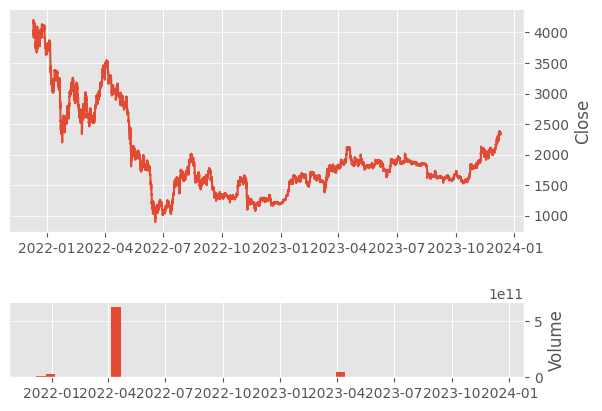

In [16]:
# Plotting closing price and volume
plot_price_vol(df)

The above looks fairly standard for data from `yfinance`. Immediately we can drop Dividends and Stock Splits given this is a crypto token and the entries are all zero in the data.

There appear to be large range of volumes (inlcuding nil volumes). The spike in volumes in May 2022 coincided with collapsed of Terra. Given the large range of values and significant outliers, thie feature could be candidate for scaling with statistics that are robust to outliers (such as `sckikit-learn`'s `RobustScaler`).

In [17]:
# Looking at the zero volume entries
df['Volume'][df['Volume'] == 0]

Datetime
2021-12-10 11:00:00+00:00    0
2021-12-10 14:00:00+00:00    0
2021-12-10 18:00:00+00:00    0
2021-12-10 20:00:00+00:00    0
2021-12-10 21:00:00+00:00    0
                            ..
2023-12-10 05:00:00+00:00    0
2023-12-10 06:00:00+00:00    0
2023-12-10 07:00:00+00:00    0
2023-12-10 08:00:00+00:00    0
2023-12-10 09:00:00+00:00    0
Name: Volume, Length: 9100, dtype: int64

The above suggests the volume data is unreliable given it is unlikely there were 375 days (i.e. 9,100 hours) where not a single transactions was registered. 

Therefore, although it reduces the data, I will drop Volume from the dataset.

In [18]:
df.drop(['Volume', 'Dividends', 'Stock Splits'], axis=1, inplace=True)
df.head()

,Open,High,Low,Close
Datetime,,,,
2021-12-10 11:00:00+00:00,4094.138428,4168.385254,4088.458496,4159.988770
2021-12-10 12:00:00+00:00,4158.929199,4194.666504,4156.186523,4171.749512
2021-12-10 13:00:00+00:00,4171.667969,4227.111816,4141.002441,4204.396484
2021-12-10 14:00:00+00:00,4205.823242,4212.586914,4028.301270,4028.301270
2021-12-10 15:00:00+00:00,4037.234131,4086.067383,3998.373779,4015.867920


### Data Cleaning


### Data Transformation


### Deep Learning Model


### Model Validation


### Backtesting

